## Research Question:

Is it possible to compare statistical difference btw populatio groups?

### 1. Specific Scenerio Code

PS - More generic code for across labels comparison in section 2

In [11]:
import json
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency

#  CONFIG 
PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
PATH_TO_ANNOTATIONS_DIR = "../data/static/gpto3mini-json-wildchat"
TARGET_COUNTRY = "France"  


In [12]:
# LOADERS 
def load_wildchat_json(path):
    with open(path, 'r') as f:
        raw = json.load(f)
    flat_records = []
    for convo in raw["data"]:
        convo_id = convo["conversation_id"]
        user_id = convo["user_id"]
        model = convo["model"]
        time = convo["time"]
        geography = convo.get("geography", None)
        for turn in convo["conversation"]:
            flat_records.append({
                "conversation_id": convo_id,
                "user_id": user_id,
                "model": model,
                "time": time,
                "geography": geography,
                "turn": turn["turn"],
                "role": turn["role"],
                "content": turn["content"]
            })
    return pd.DataFrame(flat_records)

def load_topic_labels(path):
    records = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            convo_id = data["conversation_id"]
            turn = data["turn"]
            try:
                parsed = json.loads(data["response"])
                labels = []
                for item in parsed:
                    label = item.get("labels")
                    if isinstance(label, list):
                        labels.extend(label)
                    elif isinstance(label, str):
                        labels.append(label)
                records.append({
                    "conversation_id": convo_id,
                    "turn": turn,
                    "turn_topic": labels
                })
            except:
                continue
    return pd.DataFrame(records)

In [3]:
# CHI-SQUARED TEST 
def compute_chi2_per_topic(baseline_df, target_df, label_col="turn_topic", min_count=5):
    base_counter = Counter(topic for row in baseline_df[label_col] for topic in row)
    target_counter = Counter(topic for row in target_df[label_col] for topic in row)
    all_topics = set(base_counter) | set(target_counter)

    results = []

    for topic in all_topics:
        base_count = base_counter.get(topic, 0)
        target_count = target_counter.get(topic, 0)

        if base_count + target_count < min_count:
            continue

        contingency = [
            [target_count, sum(target_counter.values()) - target_count],
            [base_count, sum(base_counter.values()) - base_count]
        ]

        try:
            chi2, p, _, _ = chi2_contingency(contingency)
            results.append({
                "topic": topic,
                "target_freq": target_count / sum(target_counter.values()),
                "base_freq": base_count / sum(base_counter.values()),
                "chi2_stat": chi2,
                "p_value": p
            })
        except:
            continue

    results_df = pd.DataFrame(results)
    results_df["abs_freq_diff"] = results_df["target_freq"] - results_df["base_freq"]
    results_df = results_df.sort_values(by="p_value")
    return results_df


In [4]:
# RUN PIPELINE

wildchat_df = load_wildchat_json(PATH_TO_DATASET)
topic_df = load_topic_labels(f"{PATH_TO_ANNOTATIONS_DIR}/turn_topic.jsonl")

# Step 2: Merge user turns with topics
user_turns = wildchat_df[wildchat_df["role"] == "user"]
merged = pd.merge(user_turns, topic_df, on=["conversation_id", "turn"], how="left").dropna(subset=["turn_topic"])

# Extract top-level country
merged["country"] = merged["geography"].fillna("Other").apply(lambda g: g.split(";")[0].strip())

# Define baseline and target groups
baseline_df = merged
target_df = merged[merged["country"] == TARGET_COUNTRY]

# chi-squared comparison
chi2_results = compute_chi2_per_topic(baseline_df, target_df)

#  Display top results
print(chi2_results[["topic", "abs_freq_diff", "target_freq", "base_freq", "p_value"]].head(10))


                                        topic  abs_freq_diff  target_freq  \
23                    Adult & Illicit Content       0.113772     0.172414   
15           Entertainment, Hobbies & Leisure       0.062627     0.111406   
21             Fantasy / Fiction / Fanfiction      -0.071040     0.013263   
11                               Art & Design      -0.040590     0.007958   
14                                  Lifestyle       0.014131     0.021220   
30                    Linguistics & Languages      -0.022834     0.010610   
5                                     History      -0.017582     0.005305   
13                       Politics & Elections      -0.012297     0.002653   
16                                     Sports      -0.011372     0.002653   
12  Non-software Engineering & Infrastructure      -0.009478     0.000000   

    base_freq       p_value  
23   0.058642  4.202115e-19  
15   0.048779  8.670758e-08  
21   0.084303  1.217552e-06  
11   0.048547  4.106040e-04  
14

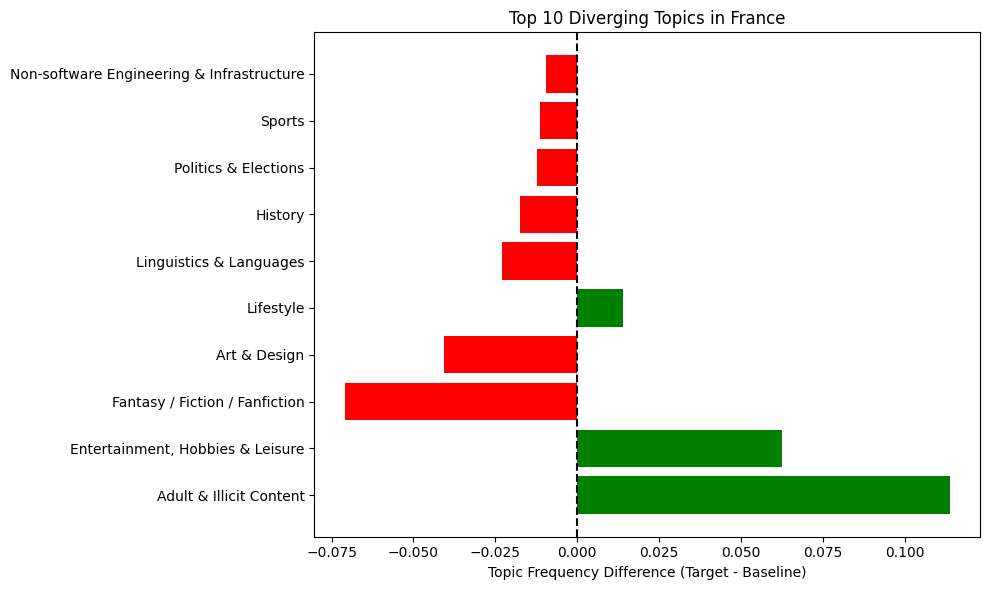

In [5]:
import matplotlib.pyplot as plt

def plot_chi2_differences(results_df, group_label, top_n=10):
    df = results_df.copy()
    df = df.sort_values("p_value").head(top_n)
    labels = df["topic"]
    diffs = df["abs_freq_diff"]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels, diffs, color=["green" if d > 0 else "red" for d in diffs])
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Topic Frequency Difference (Target - Baseline)")
    plt.title(f"Top {top_n} Diverging Topics in {group_label}")
    plt.tight_layout()
    plt.show()


plot_chi2_differences(chi2_results, TARGET_COUNTRY)


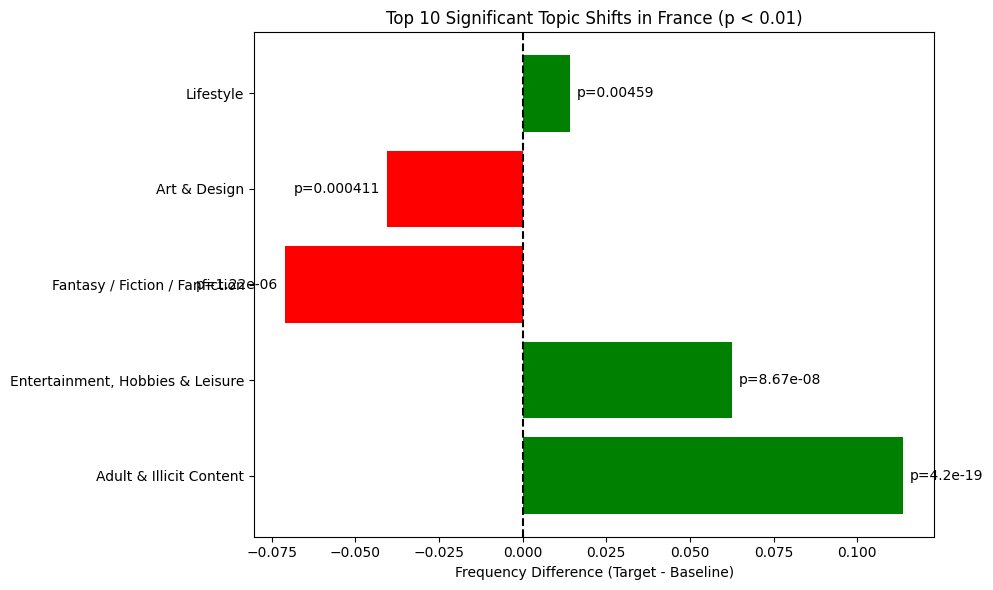

In [6]:
def plot_chi2_differences(results_df, group_label, top_n=10, p_threshold=0.01):
    df = results_df.copy()
    df = df[df["p_value"] < p_threshold]  # Only keep statistically significant topics
    df = df.sort_values("p_value").head(top_n)

    if df.empty:
        print(f"No topics with p < {p_threshold}")
        return

    labels = df["topic"]
    diffs = df["abs_freq_diff"]
    p_vals = df["p_value"]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels, diffs, color=["green" if d > 0 else "red" for d in diffs])
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Frequency Difference (Target - Baseline)")
    plt.title(f"Top {top_n} Significant Topic Shifts in {group_label} (p < {p_threshold})")

    # Annotate p-values
    for bar, p in zip(bars, p_vals):
        width = bar.get_width()
        xpos = width + 0.002 if width > 0 else width - 0.002
        plt.text(xpos, bar.get_y() + bar.get_height()/2, f"p={p:.3g}", va='center', ha='left' if width > 0 else 'right')

    plt.tight_layout()
    plt.show()

plot_chi2_differences(chi2_results, TARGET_COUNTRY)


In [26]:
# import json
# import pandas as pd
# from collections import Counter
# import matplotlib.pyplot as plt


# def load_wildchat_json(path):
#     with open(path, 'r') as f:
#         raw = json.load(f)
#     flat_records = []
#     for convo in raw["data"]:
#         convo_id = convo["conversation_id"]
#         user_id = convo["user_id"]
#         model = convo["model"]
#         time = convo["time"]
#         geography = convo.get("geography", None)
#         for turn in convo["conversation"]:
#             flat_records.append({
#                 "conversation_id": convo_id,
#                 "user_id": user_id,
#                 "model": model,
#                 "time": time,
#                 "geography": geography,
#                 "turn": turn["turn"],
#                 "role": turn["role"],
#                 "content": turn["content"]
#             })
#     return pd.DataFrame(flat_records)


# def load_topic_labels(path):
#     records = []
#     with open(path, 'r') as f:
#         for line in f:
#             data = json.loads(line)
#             convo_id = data["conversation_id"]
#             turn = data["turn"]
#             try:
#                 parsed = json.loads(data["response"])
#                 labels = []
#                 for item in parsed:
#                     label = item.get("labels")
#                     if isinstance(label, list):
#                         labels.extend(label)
#                     elif isinstance(label, str):
#                         labels.append(label)
#                 records.append({
#                     "conversation_id": convo_id,
#                     "turn": turn,
#                     "turn_topic": labels
#                 })
#             except:
#                 continue
#     return pd.DataFrame(records)


# def compare_topic_distributions(baseline_df, group_df, label_col="turn_topic"):
#     def get_counts(df):
#         return Counter(topic for row in df[label_col] for topic in row)
#     base = get_counts(baseline_df)
#     group = get_counts(group_df)
#     base_total = sum(base.values())
#     group_total = sum(group.values())
#     all_labels = set(base.keys()).union(group.keys())
#     diffs = []
#     for label in all_labels:
#         base_freq = base.get(label, 0) / base_total
#         group_freq = group.get(label, 0) / group_total
#         diffs.append((label, group_freq - base_freq, group_freq, base_freq))
#     return sorted(diffs, key=lambda x: abs(x[1]), reverse=True)


# def plot_differences_bar(diffs, group_name, top_n=10):
#     top_diffs = diffs[:top_n]
#     labels, deltas, group_freqs, base_freqs = zip(*top_diffs)
#     plt.figure(figsize=(10, 6))
#     plt.barh(labels, deltas)
#     plt.axvline(0, color='gray', linestyle='--')
#     plt.title(f"Top Diverging Topics in {group_name} vs. Baseline")
#     plt.xlabel("Topic Frequency Difference")
#     plt.tight_layout()
#     plt.show()


# wildchat_df = load_wildchat_json(PATH_TO_DATASET)
# topic_df = load_topic_labels(f"{PATH_TO_ANNOTATIONS_DIR}/turn_topic.jsonl")


# user_turns = wildchat_df[wildchat_df["role"] == "user"]
# merged = pd.merge(user_turns, topic_df, on=["conversation_id", "turn"], how="left").dropna(subset=["turn_topic"])


# merged["country"] = merged["geography"].fillna("Other").apply(lambda g: g.split(";")[0].strip())


# country = "France"  
# baseline_df = merged
# target_df = merged[merged["country"] == country]
# diffs = compare_topic_distributions(baseline_df, target_df)


# plot_differences_bar(diffs, country)

# for label, diff, target, base in diffs[:10]:
#     print(f"{label}: +{diff:.2%} (target: {target:.2%}, base: {base:.2%})")


## 2. More generic code for slicing across labels

In [62]:
from typing import List, Dict
import json
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency
from scipy.spatial.distance import jensenshannon

import matplotlib.pyplot as plt
import numpy as np


# CONFIG
PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
PATH_TO_ANNOTATIONS_DIR = "../data/static/gpto3mini-json-wildchat"

ANNOTATION_FILES = {
    "prompt_function_purpose": f"{PATH_TO_ANNOTATIONS_DIR}/prompt_function_purpose.jsonl",
    "prompt_interaction_features": f"{PATH_TO_ANNOTATIONS_DIR}/prompt_interaction_features.jsonl",
    "prompt_media_format": f"{PATH_TO_ANNOTATIONS_DIR}/prompt_media_format.jsonl",
    "prompt_multi_turn_relationship": f"{PATH_TO_ANNOTATIONS_DIR}/prompt_multi_turn_relationship.jsonl",
    "response_answer_form": f"{PATH_TO_ANNOTATIONS_DIR}/response_answer_form.jsonl",
    "response_interaction_features": f"{PATH_TO_ANNOTATIONS_DIR}/response_interaction_features.jsonl",
    "response_media_format": f"{PATH_TO_ANNOTATIONS_DIR}/response_media_format.jsonl",
    "turn_sensitive_use_flags": f"{PATH_TO_ANNOTATIONS_DIR}/turn_sensitive_use_flags.jsonl",
    "turn_topic": f"{PATH_TO_ANNOTATIONS_DIR}/turn_topic.jsonl"
}

def load_wildchat_json(path):
    with open(path, 'r') as f:
        raw = json.load(f)
    records = []
    for convo in raw["data"]:
        for turn in convo["conversation"]:
            records.append({
                "conversation_id": convo["conversation_id"],
                "user_id": convo["user_id"],
                "model": convo["model"],
                "time": convo["time"],
                "geography": convo.get("geography", None),
                "turn": turn["turn"],
                "role": turn["role"],
                "content": turn["content"]
            })
    return pd.DataFrame(records)

def load_annotation_jsonl(path, label_col_name):
    rows = []
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            convo_id = data["conversation_id"]
            turn = data["turn"]
            try:
                response = json.loads(data["response"])
                labels = []
                for entry in response:
                    val = entry.get("labels")
                    if isinstance(val, list):
                        labels.extend(val)
                    elif isinstance(val, str):
                        labels.append(val)
                rows.append({
                    "conversation_id": convo_id,
                    "turn": turn,
                    label_col_name: labels
                })
            except Exception:
                continue
    return pd.DataFrame(rows)

# ANALYSIS HELPERS 
def flatten_labels(df, label_col):
    counter = Counter()
    for row in df[label_col]:
        if isinstance(row, list):
            counter.update(row)
        elif isinstance(row, str):
            counter.update([row])
    return counter



# ANALYSIS CORE

def run_chi2_analysis(baseline_df, group_df, label_col, min_count=5):
    base_counter = flatten_labels(baseline_df, label_col)
    group_counter = flatten_labels(group_df, label_col)
    all_labels = set(base_counter) | set(group_counter)

    total_base = sum(base_counter.values())
    total_group = sum(group_counter.values())

    results = []

    for label in all_labels:
        b = base_counter.get(label, 0)
        g = group_counter.get(label, 0)
        if b + g < min_count:
            continue

        contingency = np.array([[g, total_group - g], [b, total_base - b]])
        try:
            chi2, p, dof, expected = chi2_contingency(contingency)
            observed = contingency
            residuals = (observed - expected) / np.sqrt(expected)
            std_residual = residuals[0, 0]  # residual for label in group

            results.append({
                "label": label,
                "group_freq": g / total_group,
                "base_freq": b / total_base,
                "abs_freq_diff": (g / total_group) - (b / total_base),
                "chi2_stat": chi2,
                "p_value": p,
                "std_residual": std_residual
            })
        except Exception:
            continue

    return pd.DataFrame(results).sort_values(by="p_value")


# def run_jsd_with_residuals(baseline_df, group_df, label_col, min_count=5, smoothing=1e-6):
#     base_counter = flatten_labels(baseline_df, label_col)
#     group_counter = flatten_labels(group_df, label_col)
#     all_labels = sorted(set(base_counter) | set(group_counter))

#     # Smoothed frequencies
#     base_total = sum(base_counter.values()) + smoothing * len(all_labels)
#     group_total = sum(group_counter.values()) + smoothing * len(all_labels)

#     base_probs = np.array([(base_counter.get(label, 0) + smoothing) / base_total for label in all_labels])
#     group_probs = np.array([(group_counter.get(label, 0) + smoothing) / group_total for label in all_labels])

#     # Global JSD (scalar)
#     jsd_value = jensenshannon(base_probs, group_probs, base=2) ** 2

#     results = []
#     for i, label in enumerate(all_labels):
#         b_freq = base_probs[i]
#         g_freq = group_probs[i]
#         total = b_freq + g_freq
#         if total * (base_total + group_total) / 2 < min_count:
#             continue
#         signed_residual = g_freq - b_freq
#         results.append({
#             "label": label,
#             "group_freq": g_freq,
#             "base_freq": b_freq,
#             "abs_freq_diff": abs(signed_residual),
#             "signed_freq_diff": signed_residual,
#         })

#     results_df = pd.DataFrame(results).sort_values(by="abs_freq_diff", ascending=False)
#     results_df["jsd_global"] = jsd_value
#     return results_df


# === SLICE AND ANALYZE ===
def analyze_slices(baseline_df, slices_dict: Dict[str, pd.DataFrame], annotation_cols: List[str], method="chi2", top_n=10, p_thresh=0.01):
    all_results = []
    for slice_name, slice_df in slices_dict.items():
        for label_col in annotation_cols:
            if label_col not in slice_df.columns or label_col not in baseline_df.columns:
                continue
            if method == "chi2":
                res_df = run_chi2_analysis(baseline_df, slice_df, label_col)
                res_df = res_df[res_df["p_value"] < p_thresh].sort_values(by="p_value").head(top_n)
            elif method == "jsd":
                res_df = run_jsd_with_residuals(baseline_df, slice_df, label_col)
                res_df = res_df.head(top_n)
            else:
                raise ValueError("Unknown method: choose 'chi2', or 'jsd'")
            res_df["group"] = slice_name
            res_df["annotation"] = label_col
            all_results.append(res_df)
    return pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()


def plot_differences(results_df, group_label, annotation_task, method="chi2", top_n=10):
    df = results_df[
        (results_df["group"] == group_label) &
        (results_df["annotation"] == annotation_task)
    ].head(top_n)

    if df.empty:
        print(f"No significant results for {group_label} / {annotation_task}")
        return

    label_column = "label" if "label" in df.columns else "topic"
    value_column = (
        "signed_freq_diff" if method == "jsd"
        else "abs_freq_diff" if "abs_freq_diff" in df.columns
        else "kl_div"
    )

    labels = df[label_column]
    diffs = df[value_column]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels, diffs, color=["green" if d > 0 else "red" for d in diffs])
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Signed Frequency Difference" if method == "jsd" else "Divergence Value")
    plt.title(f"Top Diverging {annotation_task} Labels in {group_label} ({method.upper()})")
    plt.tight_layout()
    plt.show()

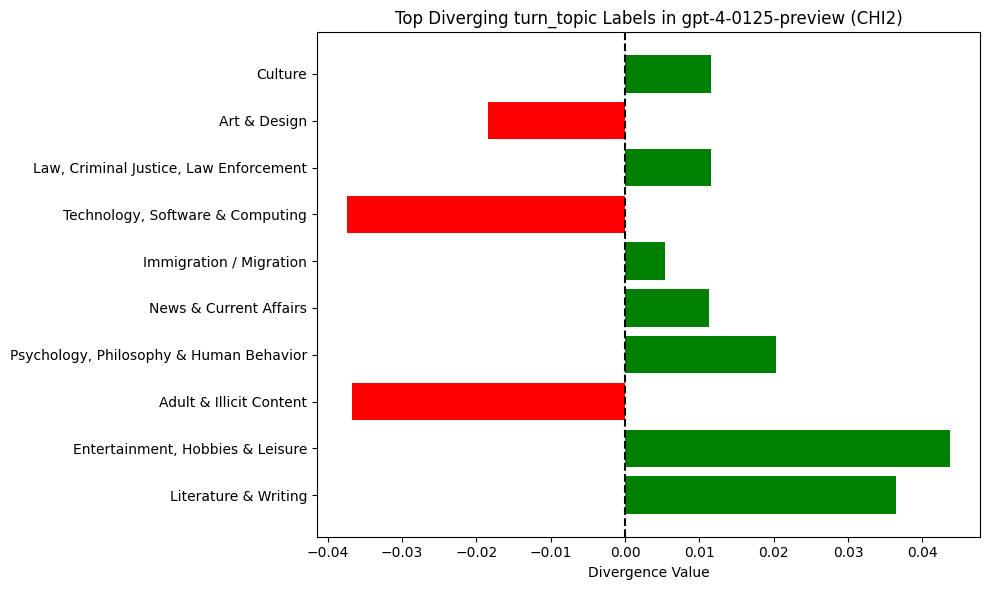

In [63]:
# Load data
wildchat_df = load_wildchat_json(PATH_TO_DATASET)
annotation_df = load_annotation_jsonl(ANNOTATION_FILES["turn_topic"], "turn_topic")
merged_df = pd.merge(wildchat_df, annotation_df, on=["conversation_id", "turn"])

# Create model slices
slices = {k: v for k, v in merged_df.groupby("model") if len(v) >= 30}
baseline_df = merged_df.copy()

# Run analysis
results = analyze_slices(baseline_df, slices, ["turn_topic"], method="chi2")

# Plot for a specific model
plot_differences(results, group_label="gpt-4-0125-preview", annotation_task="turn_topic")




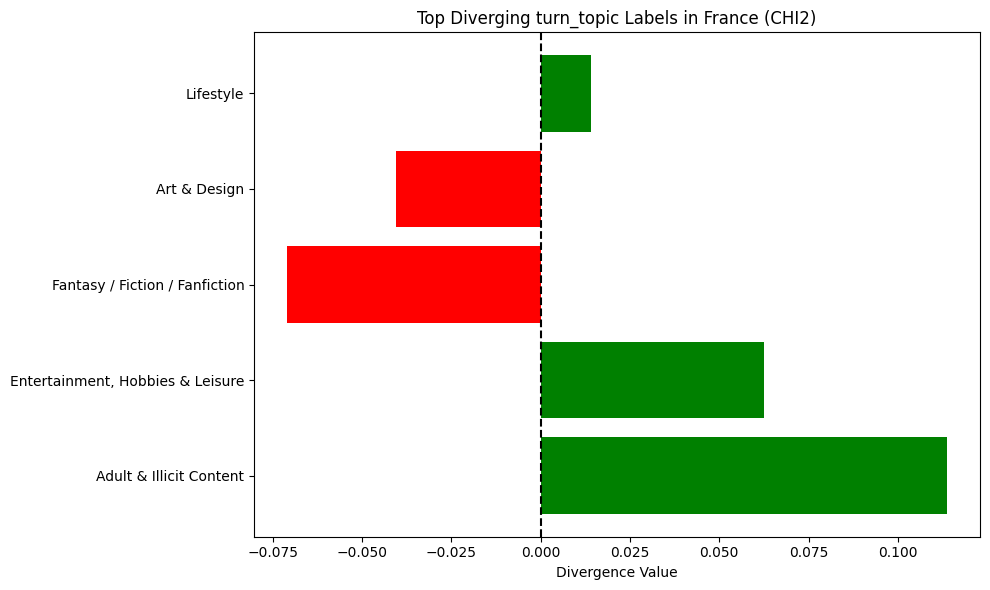

In [64]:
# Load data
wildchat_df = load_wildchat_json(PATH_TO_DATASET)
annotation_df = load_annotation_jsonl(ANNOTATION_FILES["turn_topic"], "turn_topic")
merged_df = pd.merge(wildchat_df, annotation_df, on=["conversation_id", "turn"])

# Build slices by country
merged_df["country"] = merged_df["geography"].fillna("Other").apply(lambda g: g.split(";")[0].strip())
slices = {country: df for country, df in merged_df.groupby("country") if len(df) >= 30}
baseline_df = merged_df.copy()

# Run analysis using chi-square or kl_diff or jsd
results = analyze_slices(baseline_df, slices, ["turn_topic"], method="chi2")

# Plot for a specific country
plot_differences(results, group_label="France", annotation_task="turn_topic")
